<h1>Analyse der Ausführungszeiten</h1>

<h3>Importieren der Bibliotheken</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu

<h3>Laden und kombinieren der Daten</h3>

In [2]:
def load_data(java_version, dataset_name):
    filepath = f"initial_data/{dataset_name}_results_{java_version}.csv"
    data = pd.read_csv(filepath, skiprows=1, nrows=50, usecols=[1], header=None)
    return data.squeeze()

def combine_data(datasets):
    combined_data = {}
    for dataset in datasets:
        data_java8 = load_data(8, dataset)
        data_java21 = load_data(21, dataset)
        
        combined_data[dataset] = pd.DataFrame({
            'Durchlauf': range(1, 51),
            'Java 8': data_java8,
            'Java 21': data_java21
        }).set_index('Durchlauf')
        
        # Speichern der kombinierten Daten als CSV
        output_dir = "combined_data"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        combined_data[dataset].to_csv(os.path.join(output_dir, f"exTime_{dataset}_combined_data.csv"))
        
    return combined_data

# Liste der Datensätze
datasets = ["Sphere", "Floor", "Bunny", "Terrain_1", "Terrain_2"]
data_frames = combine_data(datasets)

<h3>Daten zu plotten und Durchschnittswerte einzubinden</h3>

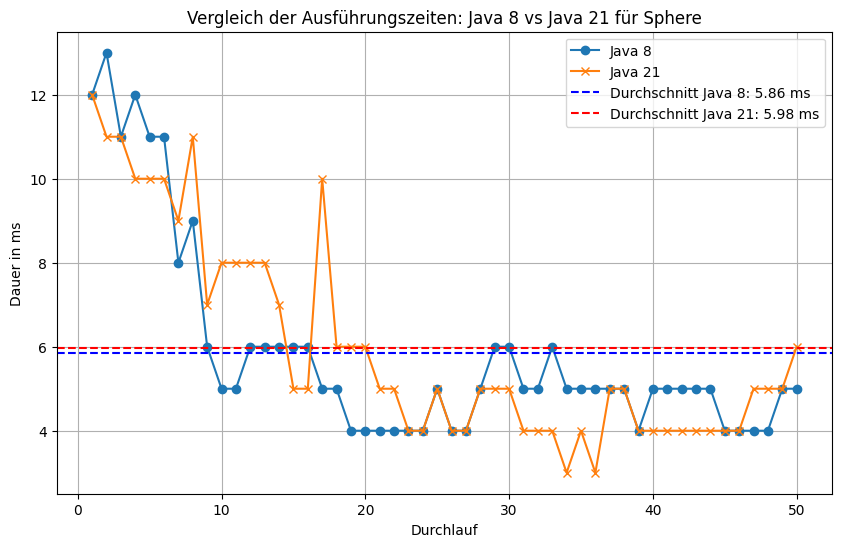

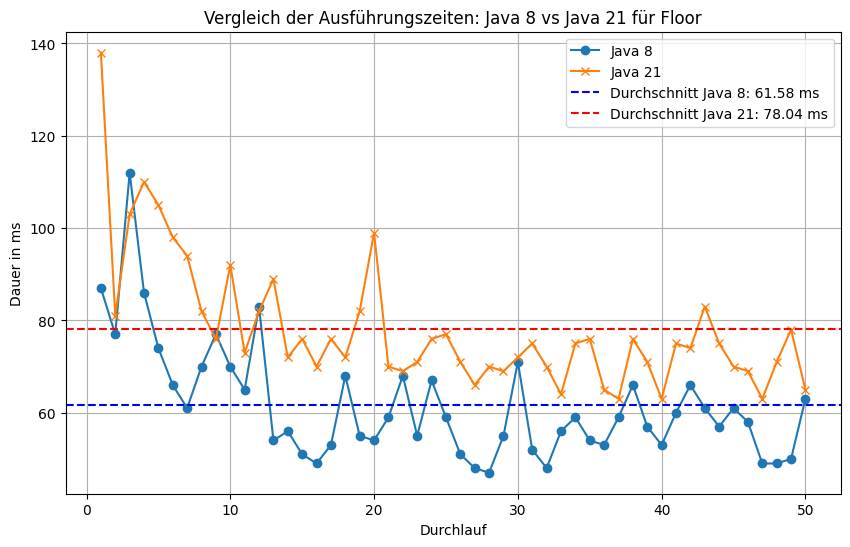

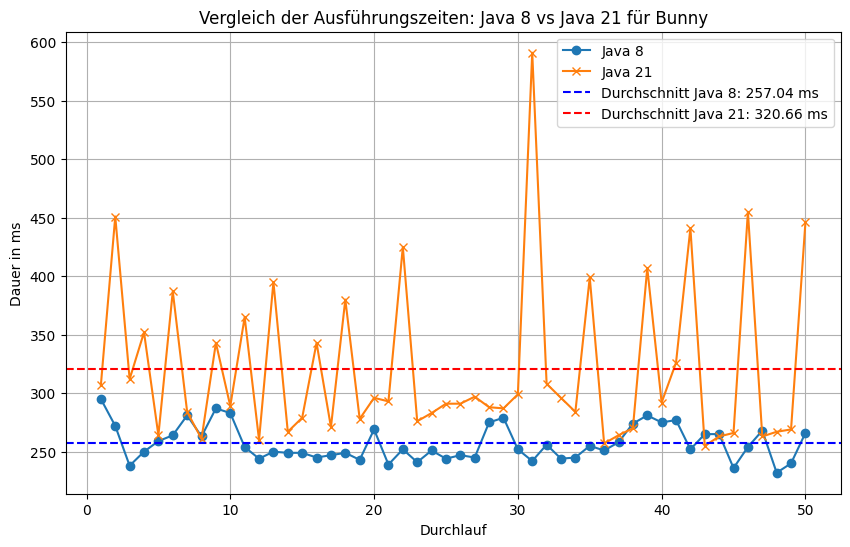

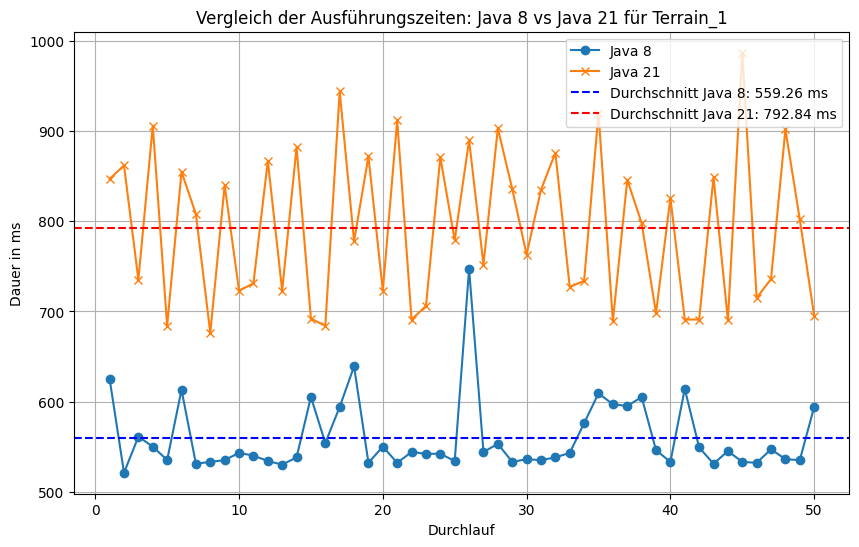

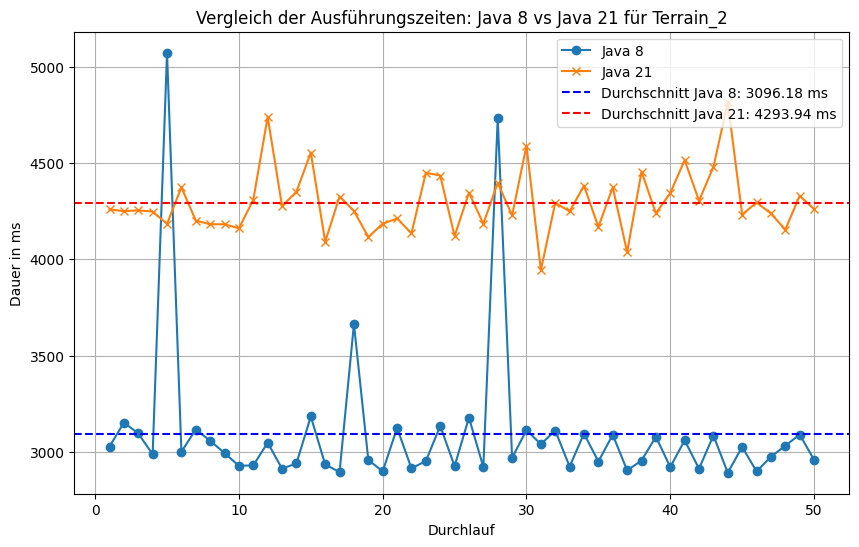

In [3]:
def plot_data(data_frames, dataset_name):
    data = data_frames[dataset_name]
    average_java8 = data['Java 8'].mean()
    average_java21 = data['Java 21'].mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['Java 8'], label='Java 8', marker='o')
    plt.plot(data['Java 21'], label='Java 21', marker='x')
    plt.axhline(y=average_java8, color='blue', linestyle='--', label=f'Durchschnitt Java 8: {average_java8:.2f} ms')
    plt.axhline(y=average_java21, color='red', linestyle='--', label=f'Durchschnitt Java 21: {average_java21:.2f} ms')
    plt.title(f'Vergleich der Ausführungszeiten: Java 8 vs Java 21 für {dataset_name}')
    plt.xlabel('Durchlauf')
    plt.ylabel('Dauer in ms')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"performance_comparison/ex_time_comparison_{dataset_name}.png")
    plt.show()

# Plots für jeden Datensatz generieren und speichern
for dataset in datasets:
    plot_data(data_frames, dataset)

<h3>Statistische Analyse mittels Mann-Whitney-U-Test</h3>

In [4]:
# Funktion zum Durchführen des Mann-Whitney-U-Tests und Speichern der Ergebnisse
def perform_mann_whitney_u_test(dataset_name, df):
    results = {}
    
    # Mann-Whitney-U-Test für Ausführungszeiten
    exec_time_stat, exec_time_p_value = mannwhitneyu(df['Java 8'], df['Java 21'])
    results['Execution_Time'] = {'statistic': exec_time_stat, 'p_value': exec_time_p_value}
    
    return results

# Funktion zum Bewerten und Ausgeben der Testergebnisse
def evaluate_results(dataset_name, test_results, df):
    significance_level = 0.05
    evaluations = []
    
    for metric in ['Execution_Time']:
        p_value = test_results[metric]['p_value']
        mean_java8 = df['Java 8'].mean()
        mean_java21 = df['Java 21'].mean()
        evaluations.append(f"Mittelwert Java 8: {mean_java8:.2f} ms, Mittelwert Java 21: {mean_java21:.2f} ms")
        if p_value < significance_level:
            better_version = 'Java 21' if mean_java21 < mean_java8 else 'Java 8'
            evaluations.append(f"{metric}: Signifikante Unterschiede festgestellt. Bessere Leistung: {better_version}.")
        else:
            evaluations.append(f"{metric}: Keine signifikanten Unterschiede festgestellt.")
        
    
    return evaluations

# Durchführen des Mann-Whitney-U-Tests für jedes Datenset und Ausgabe der Ergebnisse
for dataset_name in datasets:
    df = pd.read_csv(f'combined_data/exTime_{dataset_name}_combined_data.csv', index_col=0)
    test_results = perform_mann_whitney_u_test(dataset_name, df)
    
    print(f"Ergebnisse des Mann-Whitney-U-Tests für {dataset_name}:")
    for metric, result in test_results.items():
        print(f"{metric} - Statistik: {result['statistic']}, p-Wert: {result['p_value']}")
    
    evaluations = evaluate_results(dataset_name, test_results, df)
    for evaluation in evaluations:
        print(evaluation)
    print()


Ergebnisse des Mann-Whitney-U-Tests für Sphere:
Execution_Time - Statistik: 1289.0, p-Wert: 0.7839517582258936
Mittelwert Java 8: 5.86 ms, Mittelwert Java 21: 5.98 ms
Execution_Time: Keine signifikanten Unterschiede festgestellt.

Ergebnisse des Mann-Whitney-U-Tests für Floor:
Execution_Time - Statistik: 353.0, p-Wert: 6.25036009049542e-10
Mittelwert Java 8: 61.58 ms, Mittelwert Java 21: 78.04 ms
Execution_Time: Signifikante Unterschiede festgestellt. Bessere Leistung: Java 8.

Ergebnisse des Mann-Whitney-U-Tests für Bunny:
Execution_Time - Statistik: 251.0, p-Wert: 5.805332606406814e-12
Mittelwert Java 8: 257.04 ms, Mittelwert Java 21: 320.66 ms
Execution_Time: Signifikante Unterschiede festgestellt. Bessere Leistung: Java 8.

Ergebnisse des Mann-Whitney-U-Tests für Terrain_1:
Execution_Time - Statistik: 21.0, p-Wert: 2.4507608357113615e-17
Mittelwert Java 8: 559.26 ms, Mittelwert Java 21: 792.84 ms
Execution_Time: Signifikante Unterschiede festgestellt. Bessere Leistung: Java 8.

Erg